# Exploratory Data Analysis Political leaning data

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
# Load the data
df = pd.read_csv('../data/political_leaning.csv')

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57231 entries, 0 to 57230
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   auhtor_ID          57231 non-null  object
 1   post               57231 non-null  object
 2   political_leaning  57231 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB
None
     auhtor_ID                                               post  \
0  t2_7ramzeng  You can "buy" the show and stream it through t...   
1  t2_7ramzeng  me want to play Q*bert Holy shit, based Alex J...   
2  t2_7ramzeng  Shouldn't rely on any external services or per...   
3  t2_7ramzeng  PR to a specific person. Usually that just mea...   
4  t2_7ramzeng  This article's intention is clear that they wa...   

  political_leaning  
0             right  
1             right  
2             right  
3             right  
4             right  


In [4]:
print("Rows:", len(df))
print("Unique authors:", df['auhtor_ID'].nunique()) # There is a typo in the data column name lol
print(f"Null values: \n{df.isnull().sum()}")

Rows: 57231
Unique authors: 2178
Null values: 
auhtor_ID            0
post                 0
political_leaning    0
dtype: int64


Normalized value counts (percentage breakdown):
political_leaning
center    0.440338
right     0.304975
left      0.254687
Name: proportion, dtype: float64


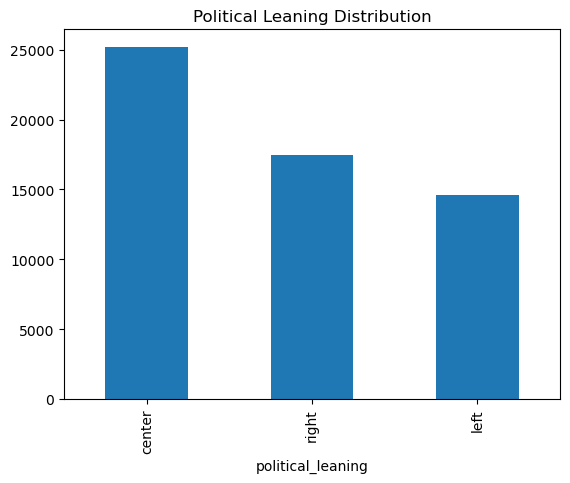

In [5]:
# What does the label distribution look like?
print(f'Normalized value counts (percentage breakdown):\n{df['political_leaning'].value_counts(normalize=True)}')

df['political_leaning'].value_counts().plot(kind='bar')
plt.title("Political Leaning Distribution")
plt.show()

                  char_count                                                   \
                       count         mean         std     min     25%     50%   
political_leaning                                                               
center               25201.0  8362.241221  797.464160  1512.0  8179.0  8413.0   
left                 14576.0  8305.458150  811.199258  1508.0  8166.0  8382.0   
right                17454.0  8271.274378  835.240151  1500.0  8133.0  8354.0   

                                    word_count                           \
                       75%      max      count         mean         std   
political_leaning                                                         
center             8657.00  23533.0    25201.0  1482.445062  119.036404   
left               8614.25  16230.0    14576.0  1479.800768  128.217116   
right              8582.00  12518.0    17454.0  1479.643291  127.673220   

                                                          
   

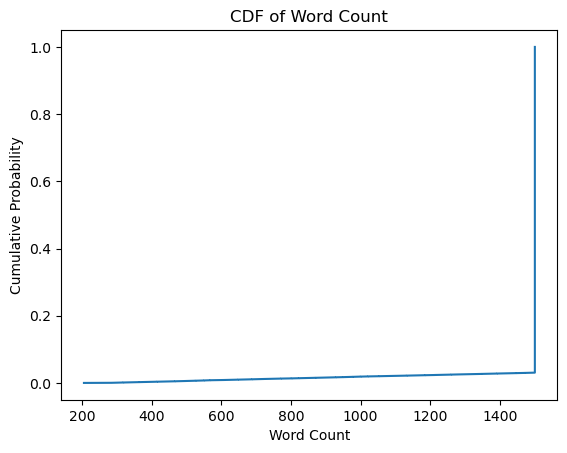

In [ ]:
# What does the text look like?

# Add a new column that has the length of each post's string
df['char_count'] = df['post'].str.len()
df['word_count'] = df['post'].str.split().str.len()

print(df.groupby('political_leaning')[['char_count', 'word_count']].describe())

sorted_wc = np.sort(df['word_count'])
cdf = np.arange(len(sorted_wc)) / len(sorted_wc)

plt.figure()
plt.plot(sorted_wc, cdf)
plt.xlabel("Word Count")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Word Count")
plt.show()

From the looks of the word count distribution the posts get cut off at 1500 words (since the 25 percentile is the same as the max) However the max word counts are higher for each of the leanings, so there are some posts with more somehow. \\
Also, the VAST majority of the posts seem to reach the word limit as seen in the cumulative distribution function.

In [23]:
# Apply tokenization

def tokenize(text):
    return [w.lower() for w in re.findall(r'\b\w+\b', text)]

df['tokens'] = df['post'].apply(tokenize)

In [ ]:
# Is there a lot of similar repitition/re-used words per post?
df['unique_tokens'] = df['tokens'].apply(lambda x: len(set(x)))
df['lexical_diversity'] = df['unique_tokens'] / df['word_count']

df.groupby('political_leaning')['lexical_diversity'].mean()

political_leaning
center    0.424989
left      0.428551
right     0.426922
Name: lexical_diversity, dtype: float64

In [ ]:
# What are the most common words?
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1,2)
)

X = tfidf.fit_transform(df['post'])

feature_names = np.array(tfidf.get_feature_names_out())

def top_tfidf_terms(label, n=50):
    # Boolean mask
    idx = df['political_leaning'] == label
    # Convert to integer row indices for sparse matrix
    row_indices = np.where(idx.to_numpy())[0]
    
    # Compute mean TF-IDF for these rows
    mean_tfidf = X[row_indices].mean(axis=0).A1
    
    # Get top n indices
    top_idx = mean_tfidf.argsort()[-n:][::-1]
    
    return feature_names[top_idx]

print(f'Top words right:\n{top_tfidf_terms('right')}')
print(f'Top words center:\n{top_tfidf_terms('center')}')
print(f'Top words left:\n{top_tfidf_terms('left')}')


# This takes a few minutes, don't worry it's working

Top words right:
['just' 'like' 'people' 'don' 'gt' 'think' 'good' 'time' 'know' 'really'
 'want' 'url' 'right' 'game' 've' 'make' 'government' 'lol' 'way' 'doesn'
 'going' 'did' 'got' 'll' 'isn' 'yeah' 'need' 'say' 'shit' 'didn' 'better'
 'thing' 'state' 'work' 'actually' 'money' 'use' 'pretty' 'probably'
 'sure' 'bad' 'does' 'years' 'based' 'said' 'lot' 'things' 'point' 'yes'
 'new']
Top words center:
['just' 'like' 'people' 'don' 'gt' 'sunflower' 'think' 'good' 'url' 'know'
 'really' 'time' 've' 'seeds' 'make' 'want' 'right' 'way' 'say' 'doesn'
 'did' 'going' 'actually' 'game' 'need' 'lol' 'thing' 'got' 'lot' 'better'
 'isn' 'sunflowers' 'll' 'said' 'things' 'shit' 'yeah' 'point' 'didn'
 'mean' 'use' 'probably' 'does' 'sure' 'work' 'feel' 'years' 'bad'
 'pretty' 'yes']
Top words left:
['just' 'like' 'people' 'don' 'gt' 'think' 'really' 'good' 'know' 'time'
 've' 'make' 'way' 'right' 'want' 'game' 'yeah' 'doesn' 'lol' 'going'
 'did' 'actually' 'isn' 'say' 'thing' 'shit' 'mean' 'got' 

In [39]:
# What do we know about the authors
print(f'{df['auhtor_ID'].describe()}')

author_labels = df.groupby('auhtor_ID')['political_leaning'].nunique()
print(f'Number of different author labels per author: {author_labels.value_counts()}')

count          57231
unique          2178
top       t2_sldqd7t
freq            1683
Name: auhtor_ID, dtype: object
Number of different author labels per author: political_leaning
1    2178
Name: count, dtype: int64


Here we see that there are 2178 different authors, user 't2_sldqd7t' being the one with the most posts at 1683 posts. 
I checked the 'Number of different author labels per author' to see if there were any inconsistencies with labels, but it seems all authors only have 1 associated political leaning. 

# Overall Takeaways:
- There are 57231 posts in the data
- There are 2178 different authors
- This makes the average number of posts per user ~26 posts, but there are outliers such as 't2_sldqd7t' with 1683 posts
- The data is not missing any values
- Each authors' leaning is consistent across all of their posts
- The different leaning labels are somewhat unbalanced with the following breakdown: 
Left: 0.254687 = 25%
Center: 0.440338 = 44%
Right: 0.304975 = 30%
- A large majority of posts has the word count of 1500 words (words having been split by any whitespace character), though some seem to be longer somehow.
- The author column in the data has a typo, this being 'Auhtor' instead (I did not change it in here, but when we start working with the data it might be nice to)
- The words used (at least the top 50 - stopwords) seem te be quite similar between the leanings. The word 'sunflower' does come up a lot in the center category. From what i can tell, this is mainly from the top user 't2_sldqd7t' who talks about sunflowers a concerning amount. They do not seem te be repeated/spammed posts though.

In [50]:
# Run this for a random sample of a post
random_post = df.sample()
print(f'Author: {random_post['auhtor_ID']}\nLeaning:{random_post['political_leaning']}\nPost:\n{random_post['post'].values[0]}')

Author: 47584    t2_4w5yp
Name: auhtor_ID, dtype: object
Leaning:47584    left
Name: political_leaning, dtype: object
Post:
Egyptians. Unfortunately we'll never know unless some linguist makes a breakthrough in translating it. I think you're taking a small kernel of truth and running to the fucking endzone with it. The vaccine doesn't reduce upfront viral load but it certainly helps your body suppress the virus and reduce the load significantly faster than an unvaccinated person. How do you think it reduces symptoms? By making your tissues and organs magically just not interact with the antigen? No, it works by helping you kill the virus faster. Also idk why conservatives insist on nailing Fauci to a cross when he's not even the one who made the vaccine and all the Republicans in congress were jumping over each other to get it as soon as it was available, without him forcing them to get it. The mentality that this is somehow Fauci's fault and he's somehow hurting Americans with the vac

In [10]:
for post in df['post']:
    if 'deleted' in post:
        print(post[0:1000])

goal of helping its leaders drink Champaign. I was born in a gun fight, and I'll die in a gun fight. Omar comin' Batgirl moved to Gotham’s hip up and coming Burnside neighborhood a few years ago, then took a brief trip overseas, and came back to complain about how gentrification had changed the place so much while she was gone. My favorite part about her videos is when she spends half the time trying to do something simple like flip a dish over or pick something up with over mitts on. I never heard of this foxhole game but I’m impressed they kept their space. Reading about the game, it makes sense. The “book” costs three times as much as regular tampons, so the government still gets the same amount of taxes at the end of the day, but you pay more and libright gets rich. I assume this is like all the workout gizmos you see on TV now, where professional bodybuilders and models show off a device that promises abs in 30 minutes a week. It’s not that people don’t know about fitness. It’s th